In [1]:
your_client_id='ElyKc6o3du1IMb5LP2HYjg'
your_client_secret='YimfVn3bTLyVFu_XkJuLxrNkR3vHAQ'
your_user_name='guntsv'
# https://www.reddit.com/prefs/apps

In [6]:
import pandas as pd
import numpy as np

# misc
import datetime as dt
from pprint import pprint
from itertools import chain

#spacy 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# reddit crawler
import praw

# # sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
reddit = praw.Reddit(client_id=your_client_id,
                     client_secret=your_client_secret,
                     user_agent=your_user_name,
                     check_for_async=False)

In [4]:
subreddit = reddit.subreddit('iphone')

news = [*subreddit.top(limit=None)] # top posts all time

print(len(news))

981


In [26]:
news0 = news[0]

# pprint(vars(news0)) 
print(news0.title) # headline
print(news0.score) # upvotes
print(news0.created) # UNIX timestamps 
print(dt.datetime.fromtimestamp(news0.created)) # date and time
print(news0.num_comments) # no. of comments
print(news0.upvote_ratio) # upvote / total votes
print(news0.total_awards_received) # no. of awards given

Now you can cook on it
47471
1568141987.0
2019-09-10 18:59:47
1247
0.93
7


In [5]:
title = [n.title for n in news]

In [29]:
news = pd.DataFrame({
    "title": title,
})
news.head()

,title
0,Now you can cook on it
1,Just got my first iPhone for Christmas!
2,Apple CarPlay volume control UI
3,Wait I’ve seen this one before
4,How rotation lock should be


In [30]:
news.shape

(981, 1)

## NLTK

In [37]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [39]:
sid = SentimentIntensityAnalyzer()

pos_text = "Vader is awesome"
cap_pos_text = "Vader is AWESOME!" # captilization and ! increases the effect
neg_text = "Vader is bad"

print(sid.polarity_scores(pos_text))
print(sid.polarity_scores(cap_pos_text))
print(sid.polarity_scores(neg_text))

{'neg': 0.0, 'neu': 0.328, 'pos': 0.672, 'compound': 0.6249}
{'neg': 0.0, 'neu': 0.281, 'pos': 0.719, 'compound': 0.729}
{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}


In [40]:
res = [*news['title'].apply(sid.polarity_scores)]
pprint(res[:3])

[{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]


In [41]:
sentiment_df = pd.DataFrame.from_records(res)
news = pd.concat([news, sentiment_df], axis=1, join='inner')
news.head()

,title,neg,neu,pos,compound
0,Now you can cook on it,0.0,1.0,0.0,0.0
1,Just got my first iPhone for Christmas!,0.0,1.0,0.0,0.0
2,Apple CarPlay volume control UI,0.0,1.0,0.0,0.0
3,Wait I’ve seen this one before,0.0,1.0,0.0,0.0
4,How rotation lock should be,0.0,1.0,0.0,0.0


In [42]:
THRESHOLD = 0.2

conditions = [
    (news['compound'] <= -THRESHOLD),
    (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
    (news['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
news['label'] = np.select(conditions, values)

news.head()

,title,neg,neu,pos,compound,label
0,Now you can cook on it,0.0,1.0,0.0,0.0,neu
1,Just got my first iPhone for Christmas!,0.0,1.0,0.0,0.0,neu
2,Apple CarPlay volume control UI,0.0,1.0,0.0,0.0,neu
3,Wait I’ve seen this one before,0.0,1.0,0.0,0.0,neu
4,How rotation lock should be,0.0,1.0,0.0,0.0,neu


In [43]:
sentence0 = news.title.iloc[0]
print(sentence0)
words0 = news.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0:
  if (sid.polarity_scores(word)['compound']) >= THRESHOLD:
    pos_list.append(word)
  elif (sid.polarity_scores(word)['compound']) <= -THRESHOLD:
    neg_list.append(word)
  else:
    neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sid.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
print(f"The compound value : {score['compound']} <= {-THRESHOLD}")
print(f"\nThis sentence is NEGATIVE")

# source https://stackoverflow.com/a/51515048/11386747

Now you can cook on it
['Now', 'you', 'can', 'cook', 'on', 'it']

Positive: []
Neutral: ['Now', 'you', 'can', 'cook', 'on', 'it']
Negative: []

This sentence is 0.0% negative
This sentence is 100.0% neutral
This sentence is 0.0% positive
The compound value : 0.0 <= -0.2

This sentence is NEGATIVE


<AxesSubplot: xlabel='label', ylabel='Count'>

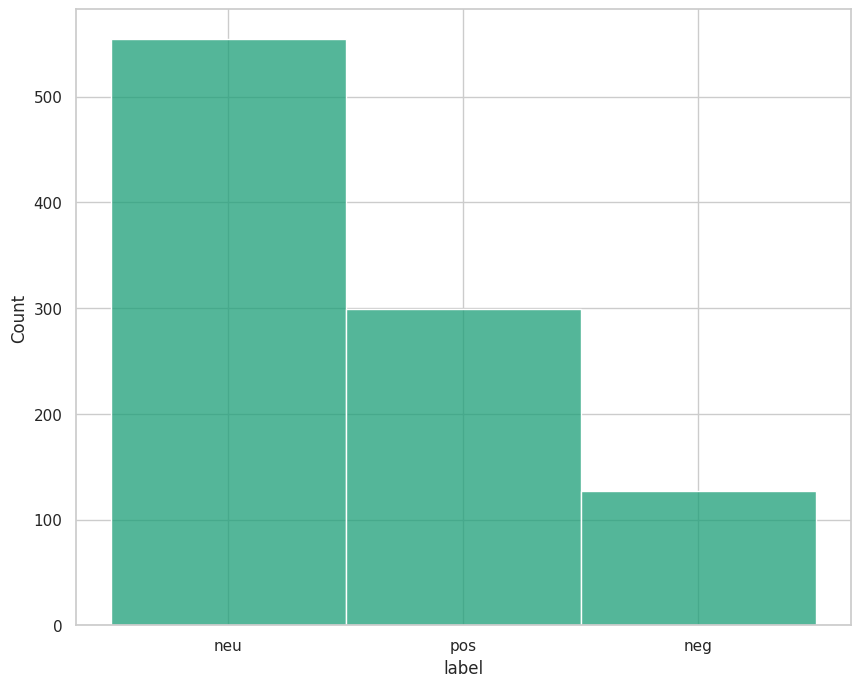

In [46]:
sns.histplot(news.label)

In [47]:
def news_title_output(df, label):
  res = df[df['label'] == label].title.values
  print(f'{"=" * 20}')
  print("\n".join(title for title in res))

# randomly sample
news_sub = news.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
news_title_output(news_sub, "pos")

print("\nNeutral news")
news_title_output(news_sub, "neu")

print("\nNegative news")
news_title_output(news_sub, "neg")

Positive news
i made this stupid iPhone animation/render a few days ago i hope you like it
People should know this, especially if your friends like to mess around!
The way this border wallpaper fades in is extremely satisfying
Celebrate! Today is one of 7 days each year where Google Calendar’s iOS app icon is correct! 🙄
Good guy Safari. Apple are really serious about its privacy.

Neutral news
Wholesome ❤️
Apple reportedly switched 2M units of production from iPhone 12 mini to Pro - 9to5Mac
Spotify iOS 14 widgets make early appearance in latest beta
Apple patent suggests that iPhone will have the same water-ejection system as Apple Watch
After less than a month of sporadic use with my iPhone 7, the dongle is already tearing.

Negative news
Guys, you weren't even kidding! Thanks for the tip! (Pun absolutely intended)
Apparently if you do this enough times, it will crash the phone. This was the last one it could handle.
I took apart my broken iPhone 4 and framed it.
Apple temporarily clo